In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Загружаем 5 вариант
data = pd.read_excel('../data/Данные_301.xls', sheet_name=4)
data.head()

,Накопленная оценка,Экзаменационная оценка
0,5,6
1,1,5
2,2,3
3,4,2
4,3,5


In [3]:
# Считаем итоговую оценку и округляем ее по математике
data['Итоговая оценка'] = (data['Накопленная оценка'] + data['Экзаменационная оценка']) / 2
# В питоне очень странно работает округление, поэтому добавляем 0.1.
# Это не изменит результат округления для целых чисел, но для чисел с .5 на конце, 
# оокругление будет в большую сторону 
data['Итоговая оценка(округленная)'] = (data['Итоговая оценка'] + 0.1).round().astype(int)

In [4]:
data.head()

,Накопленная оценка,Экзаменационная оценка,Итоговая оценка,Итоговая оценка(округленная)
0,5,6,5.5,6
1,1,5,3.0,3
2,2,3,2.5,3
3,4,2,3.0,3
4,3,5,4.0,4


In [5]:
print('Исправленное среднее отклонение:')
data.std()

Исправленное среднее отклонение:


Накопленная оценка              2.225305
Экзаменационная оценка          2.182661
Итоговая оценка                 1.970303
Итоговая оценка(округленная)    2.005178
dtype: float64

In [6]:
print('Среднее арифмитическое:')
data.mean()

Среднее арифмитическое:


Накопленная оценка              5.641414
Экзаменационная оценка          4.570707
Итоговая оценка                 5.106061
Итоговая оценка(округленная)    5.368687
dtype: float64

In [7]:
print('Медиана:')
data.median()

Медиана:


Накопленная оценка              5.5
Экзаменационная оценка          4.0
Итоговая оценка                 5.0
Итоговая оценка(округленная)    5.0
dtype: float64

<AxesSubplot:xlabel='Итоговая оценка', ylabel='Count'>

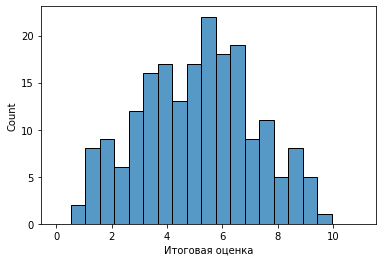

In [8]:
sns.histplot(data['Итоговая оценка'], bins=np.linspace(0, 11, 22))

<AxesSubplot:xlabel='Итоговая оценка(округленная)', ylabel='Count'>

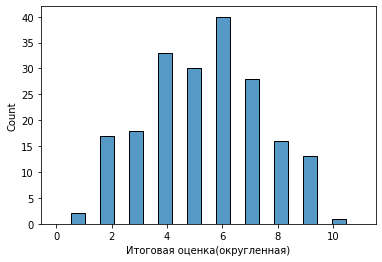

In [9]:
sns.histplot(data['Итоговая оценка(округленная)'], bins=np.linspace(0, 11, 22))

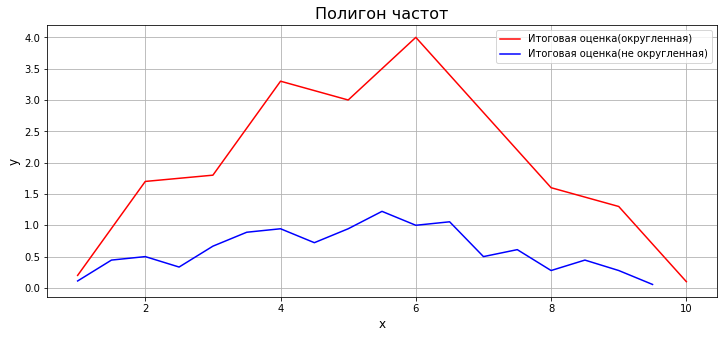

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

pos1, freq1 = np.unique(data['Итоговая оценка(округленная)'], return_counts=True)
pos2, freq2 = np.unique(data['Итоговая оценка'], return_counts=True)

plt.title('Полигон частот', fontsize=16)

plt.plot(pos1, freq1 / len(freq1), label='Итоговая оценка(округленная)', color='red')
plt.plot(pos2, freq2 / len(freq2), label='Итоговая оценка(не округленная)', color='blue')
plt.legend(loc='best')
plt.grid()

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12);

In [11]:
p_lambda = data['Итоговая оценка(округленная)'].mean()

Проверим гипотезу, что данные пришли из распределения Пуассона. Для этого сравним ожидаемые вероятности и частоты, которые мы получили. Сделаем это с помощью критерий $\chi^2$. Но так как распределение Пуассона имеет бесконечный хвост, подменим нулевую гипотезу на следующую.

H0: $p(k)=\frac{\lambda^{k}}{k !} e^{-\lambda}$ для k от 0 до 10 и хвост Пуассона отнесем к $p(k \geq 11) = 1 - \sum_{i=0}^{10}p(i)$ \
H1: иначе 

Так сумма ожидаемых вероятностей будет равна 1. Параметр $\lambda$ оценим по выборке.

In [12]:
from math import factorial 

# Найдем теор. вероятности
exp_freqs = np.array([p_lambda ** k / factorial(k) for k in range(12)]) / np.exp(p_lambda)
exp_freqs[-1] = 1 - sum(exp_freqs[:-1])

In [13]:
from scipy.stats import chi2

# Найдем частоты
obs_freqs_mul_n = np.bincount(data['Итоговая оценка(округленная)'], minlength=12)
n = sum(obs_freqs_mul_n)

In [14]:
from scipy.stats import chisquare

chisquare(obs_freqs_mul_n, exp_freqs * n) # pvalue > 0.02 => нет оснований отвергнуть H0

Power_divergenceResult(statistic=18.28847219279885, pvalue=0.07512391489145363)

In [15]:
def chi_square(expected_freqs, observed_freqs, n, alpha=0.02):
    statistic = sum((expected_freqs - observed_freqs) ** 2 / expected_freqs) * n
    border = chi2(len(expected_freqs)-1).ppf(1-alpha)
    
    print(f'Значение статистики: {statistic}')
    print(f"Критическая область:  [{border}: inf)")
    if statistic > border:
        print("Отвергаем нулевую гипотезу")
    else:
        print('Нет оснований отклонить нулевую гипотезу')
        
    return statistic

# Моя реализация
chi_square(exp_freqs, obs_freqs_mul_n/n,  n, 0.02);

Значение статистики: 18.28847219279885
Критическая область:  [22.617940805565944: inf)
Нет оснований отклонить нулевую гипотезу


In [16]:
# Проверим гипотезу о нормальности
from scipy.stats import normaltest, shapiro, norm

Разбиваем на следующие интервалы (-inf 0.5]u(0.5 1.5]u(1.5, 2.5]u...u(9.5,10.5]u(10.5, inf)

In [32]:
# Сначала с помощью chi2
mean, std = data['Итоговая оценка(округленная)'].mean(), data['Итоговая оценка(округленная)'].std()

observed_count = np.zeros(13)
observed_count[1:-1] = np.bincount(data['Итоговая оценка(округленная)'])
n = sum(observed_count)

intervals = np.linspace(0, 11, 12) - 0.5
exp_freqs = np.zeros(13)

for i in range(len(exp_freqs)):
    if i==0:
        exp_freqs[0] = norm(mean, std).cdf(intervals[i])
    elif i==len(exp_freqs)-1:
        exp_freqs[i] = 1 - norm(mean, std).cdf(intervals[i-1])
    else:
        exp_freqs[i] = norm(mean, std).cdf(intervals[i]) - norm(mean, std).cdf(intervals[i-1])


print('Частоты теоретические', exp_freqs)
print('Наблюдаемые частоты, умноженные на n', observed_count, '\n')

# Схлопним первые 4 значения, и последние 3, чтобы n * p_obs > 5,
exp_freqs[3] = exp_freqs[:4].sum()
observed_count[3] = observed_count[:4].sum()

exp_freqs[-3] = exp_freqs[-3:].sum()
observed_count[-3] = observed_count[-3:].sum()

new_exp_freqs = exp_freqs[3:-2]
new_observed_count = observed_count[3: -2]

print('Новые')
print('Частоты теоретические', new_exp_freqs)
print('Наблюдаемые частоты, умноженные на n', new_observed_count, '\n')

print('Сумма ожидаемых частот:', new_exp_freqs.sum()) # Сумма 1, значит все правильно
chi_square(exp_freqs, observed_count/n,  n, 0.05);

Частоты теоретические [0.00171254 0.00587745 0.01925385 0.04942298 0.09941941 0.15674062
 0.19368003 0.18758267 0.14239783 0.08472307 0.03950568 0.01443566
 0.00524822]
Наблюдаемые частоты, умноженные на n [ 0.  0.  2. 17. 18. 33. 30. 40. 28. 16. 13.  1.  0.] 

Новые
Частоты теоретические [0.07626682 0.09941941 0.15674062 0.19368003 0.18758267 0.14239783
 0.08472307 0.05918956]
Наблюдаемые частоты, умноженные на n [19. 18. 33. 30. 40. 28. 16. 14.] 

Сумма ожидаемых частот: 1.0
Значение статистики: 8.405564420020145
Критическая область:  [21.02606981748307: inf)
Нет оснований отклонить нулевую гипотезу


In [18]:
# Так же есть более мощные критерии для проверки нормальности. Например D’Agostino
# https://en.wikipedia.org/wiki/D%27Agostino%27s_K-squared_test, там действительно большие формулы,
# поэтому я реализовал xi^2
normaltest(data['Итоговая оценка(округленная)'])

NormaltestResult(statistic=8.482400162086913, pvalue=0.014390311935977935)

In [19]:
# Или самый мощный - Шапиро Уилко
shapiro(data['Итоговая оценка(округленная)'])

ShapiroResult(statistic=0.9654703140258789, pvalue=8.853968029143289e-05)

Видно, что Шапиро и normaltest отклоняют гипотезу о нормальности, в то время, как Хи квадрат этого не делает.

In [20]:
# Проверим гипотезу о том, что половине студентам повезло и им поставили округлили вверх,
# а половине оставили их баллы. (так же с помощью xi^2)
diff = data['Итоговая оценка(округленная)'] - data['Итоговая оценка']

In [25]:
# H0: p1 = p2 = 1/2
# H1: иначе

obs_freqs_mul_n = np.bincount(diff+0.5)
n = len(diff)
exp_freqs = np.array([1/2, 1/2])

chisquare(obs_freqs_mul_n, exp_freqs * n)

Power_divergenceResult(statistic=0.5050505050505051, pvalue=0.4772893402694306)

Так же нет оснований отклонить гипотезу о равномерности

Рассотрим гипотезу, что среднее до округления и после равны

In [22]:
from scipy.stats import f_oneway

f_oneway(data['Итоговая оценка(округленная)'], data['Итоговая оценка'])

F_onewayResult(statistic=1.72805896359543, pvalue=0.18942366707628355)

In [23]:
ttest_ind(data['Итоговая оценка(округленная)'], data['Итоговая оценка'], equal_var=True)

Ttest_indResult(statistic=1.314556565384473, pvalue=0.18942366707628916)

Не можем отвергнуть гипотезу о равенстве средних